# Retail Product Recommendations using word2vec
> Creating a system that automatically recommends a certain number of products to the consumers on an E-commerce website based on the past purchase behavior of the consumers.

- toc: true
- badges: true
- comments: true
- categories: [sequence retail]
- image: 

A person involved in sports-related activities might have an online buying pattern similar to this:

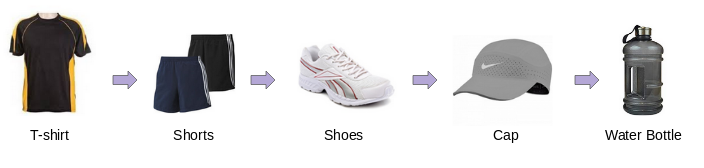

If we can represent each of these products by a vector, then we can easily find similar products. So, if a user is checking out a product online, then we can easily recommend him/her similar products by using the vector similarity score between the products.

In [ ]:
#hide
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

## Data gathering and understanding

In [ ]:
#hide-output
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

--2021-04-24 06:43:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23715344 (23M) [application/x-httpd-php]
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx  100%[===================>]  22.62M  24.6MB/s    in 0.9s    

2021-04-24 06:43:15 (24.6 MB/s) - ‘Online Retail.xlsx’ saved [23715344/23715344]



In [ ]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Given below is the description of the fields in this dataset:

1. __InvoiceNo:__ Invoice number, a unique number assigned to each transaction.

2. __StockCode:__ Product/item code. a unique number assigned to each distinct product.

3. __Description:__ Product description

4. __Quantity:__ The quantities of each product per transaction.

5. __InvoiceDate:__ Invoice Date and time. The day and time when each transaction was generated.

6. __CustomerID:__ Customer number, a unique number assigned to each customer.

## Data Preprocessing

In [ ]:
# check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Since we have sufficient data, we will drop all the rows with missing values.

In [ ]:
# remove missing values
df.dropna(inplace=True)

# again check missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
# Convert the StockCode to string datatype
df['StockCode']= df['StockCode'].astype(str)

In [ ]:
# Check out the number of unique customers in our dataset
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

There are 4,372 customers in our dataset. For each of these customers we will extract their buying history. In other words, we can have 4,372 sequences of purchases.

## Data Preparation

It is a good practice to set aside a small part of the dataset for validation purpose. Therefore, we will use data of 90% of the customers to create word2vec embeddings. Let's split the data.

In [ ]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

Let's create sequences of purchases made by the customers in the dataset for both the train and validation set.

In [ ]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:06<00:00, 611.49it/s]


In [ ]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 936.13it/s]


## Build word2vec Embeddings for Products

In [ ]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3702587, 3739130)

In [ ]:
# save word2vec model
model.save("word2vec_2.model")

As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient

In [ ]:
model.init_sims(replace=True)

In [ ]:
print(model)

Word2Vec(vocab=3183, size=100, alpha=0.03)


Now we will extract the vectors of all the words in our vocabulary and store it in one place for easy access

In [ ]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3183, 100)

## Visualize word2vec Embeddings

It is always quite helpful to visualize the embeddings that you have created. Over here we have 100 dimensional embeddings. We can't even visualize 4 dimensions let alone 100. Therefore, we are going to reduce the dimensions of the product embeddings from 100 to 2 by using the UMAP algorithm, it is used for dimensionality reduction.

In [ ]:
#hide
!pip install umap-learn

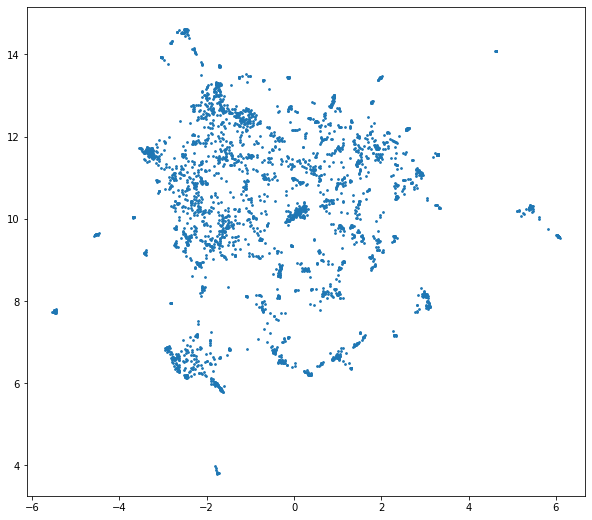

In [ ]:
#collapse-input
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

Every dot in this plot is a product. As you can see, there are several tiny clusters of these datapoints. These are groups of similar products.

## Generate and validate recommendations

We are finally ready with the word2vec embeddings for every product in our online retail dataset. Now our next step is to suggest similar products for a certain product or a product's vector. 

Let's first create a product-ID and product-description dictionary to easily map a product's description to its ID and vice versa.

In [ ]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [ ]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

We have defined the function below. It will take a product's vector (n) as input and return top 6 similar products.

In [ ]:
#hide
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

Let's try out our function by passing the vector of the product '90019A' ('SILVER M.O.P ORBIT BRACELET')

In [ ]:
similar_products(model['90019A'])

[('BLUE MURANO TWIST BRACELET', 0.7672459483146667),
 ('WHITE VINT ART DECO CRYSTAL NECKLAC', 0.760308027267456),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7595000267028809),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7458198070526123),
 ('JADE DROP EARRINGS W FILIGREE', 0.7301571369171143),
 ('PINK BOUDICCA LARGE BRACELET', 0.7271137833595276)]

Cool! The results are pretty relevant and match well with the input product. However, this output is based on the vector of a single product only. What if we want recommend a user products based on the multiple purchases he or she has made in the past?

One simple solution is to take average of all the vectors of the products he has bought so far and use this resultant vector to find similar products. For that we will use the function below that takes in a list of product ID's and gives out a 100 dimensional vector which is mean of vectors of the products in the input list.

In [ ]:
#collapse-input
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

If you can recall, we have already created a separate list of purchase sequences for validation purpose. Now let's make use of that.

In [ ]:
#hide
len(purchases_val[0])

30

The length of the first list of products purchased by a user is 314. We will pass this products' sequence of the validation set to the function aggregate_vectors.

In [ ]:
#hide
aggregate_vectors(purchases_val[0]).shape

(100,)

Well, the function has returned an array of 100 dimension. It means the function is working fine. Now we can use this result to get the most similar products. Let's do it.

In [ ]:
similar_products(aggregate_vectors(purchases_val[0]))

[('JUMBO BAG APPLES', 0.8122212886810303),
 ('JUMBO BAG ALPHABET', 0.7919023633003235),
 ('JUMBO BAG VINTAGE LEAF', 0.7833157777786255),
 ('JUMBO BAG PEARS', 0.7778137922286987),
 ('JUMBO BAG DOLLY GIRL DESIGN', 0.7596017122268677),
 ('JUMBO BAG SPACEBOY DESIGN', 0.7426352500915527)]

As it turns out, our system has recommended 6 products based on the entire purchase history of a user. Moreover, if you want to get products suggestions based on the last few purchases only then also you can use the same set of functions.

Below we are giving only the last 10 products purchased as input.

In [ ]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('JUMBO BAG VINTAGE DOILY ', 0.7459125518798828),
 ('JUMBO BAG VINTAGE CHRISTMAS ', 0.7247202396392822),
 ('JUMBO BAG VINTAGE LEAF', 0.6814517974853516),
 ('JUMBO BAG PAISLEY PARK', 0.6675525903701782),
 ('VINTAGE DOILY JUMBO BAG RED ', 0.6659834384918213),
 ('JUMBO BAG PEARS', 0.6639658808708191)]

## References

- [https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/](https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/)
- [https://mccormickml.com/2018/06/15/applying-word2vec-to-recommenders-and-advertising/](https://mccormickml.com/2018/06/15/applying-word2vec-to-recommenders-and-advertising/)
- [https://www.analyticsinsight.net/building-recommendation-system-using-item2vec/](https://www.analyticsinsight.net/building-recommendation-system-using-item2vec/)
- [https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484](https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484)
- [https://capablemachine.com/2020/06/23/word-embedding/](https://capablemachine.com/2020/06/23/word-embedding/)